                 Entry Index                Exit Index  Type  Entry Price  \
0  2024-05-09 10:55:00+05:30 2024-05-09 11:20:00+05:30   Put        60.35   
1  2024-05-09 11:05:00+05:30 2024-05-09 11:30:00+05:30   Put        45.00   
2  2024-05-09 11:40:00+05:30 2024-05-09 12:05:00+05:30   Put        60.35   
3  2024-05-09 11:55:00+05:30 2024-05-09 12:20:00+05:30   Put        60.35   
4  2024-05-09 12:10:00+05:30 2024-05-09 12:35:00+05:30   Put        60.35   
..                       ...                       ...   ...          ...   
84 2024-05-14 14:45:00+05:30 2024-05-14 15:10:00+05:30  Call       175.20   
85 2024-05-14 14:50:00+05:30 2024-05-14 15:15:00+05:30   Put        79.85   
86 2024-05-14 15:10:00+05:30 2024-05-14 15:25:00+05:30  Call       175.20   
87 2024-05-14 15:15:00+05:30 2024-05-14 15:25:00+05:30   Put        79.85   
88 2024-05-14 15:20:00+05:30 2024-05-14 15:25:00+05:30  Call       175.20   

    Exit Price        P&L  
0        66.30    9859.15  
1        62.15   38

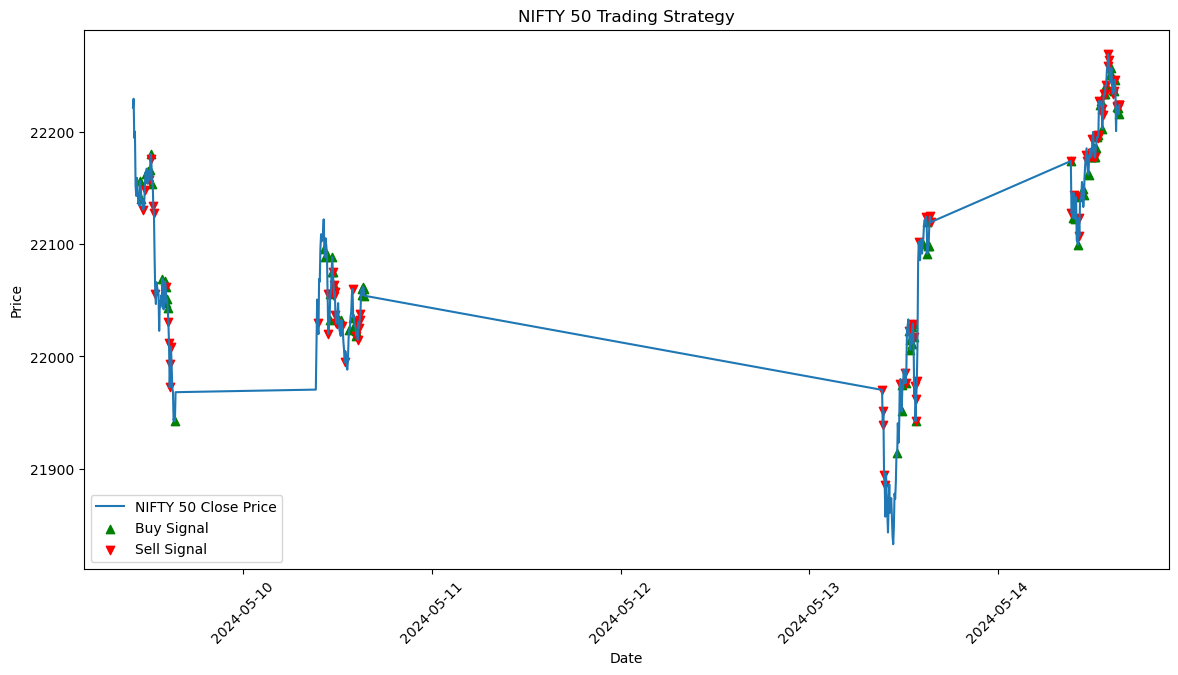

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

def load_options_data(folder):
    data_list = []
    for file in os.listdir(folder):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(folder, file))
            data_list.append(df)
    return pd.concat(data_list, ignore_index=True)

nifty_data = pd.read_csv(r"C:\Users\dubey\OneDrive\Concated Data\NIFTY 50 stock data.csv")
nifty_data['Date'] = pd.to_datetime(nifty_data['Date'], format='%a %b %d %Y %H:%M:%S GMT%z (India Standard Time)', errors='coerce')
nifty_data.dropna(subset=['Date'], inplace=True)
nifty_data.set_index('Date', inplace=True)

call_options = load_options_data(r"C:\Users\dubey\OneDrive\Concated Data\Call option")
put_options = load_options_data(r"C:\Users\dubey\OneDrive\Concated Data\Put Option")

#closest OTM option
def select_otm_option(options_df, current_price, option_type):
    if option_type == 'call':
        otm_options = options_df[options_df['Strike Price'] > current_price]
    elif option_type == 'put':
        otm_options = options_df[options_df['Strike Price'] < current_price]
    else:
        raise ValueError("Invalid option type. Must be 'call' or 'put'.")
    
    if otm_options.empty:
        return None
    
    closest_otm_option = otm_options.iloc[(otm_options['Strike Price'] - current_price).abs().argsort()[:1]]
    return closest_otm_option.iloc[0] 

trades = []
capital_per_trade = 100000
total_invested = 0
total_pnl = 0

# bullish sentiment
def is_bullish(nifty_df, options_df, current_index):
    if current_index < 3:
        return False
    
    current_close = nifty_df.iloc[current_index]['Close']
    prev_close = nifty_df.iloc[current_index - 3]['Close']
    
    if current_close >= prev_close:
        return False
    
    otm_call = select_otm_option(options_df, current_close, 'call')
    if otm_call is None:
        return False
    
    prev_oi = options_df.iloc[current_index - 1]['OI']
    current_oi = options_df.iloc[current_index]['OI']
    
    if current_oi >= prev_oi:
        return False
    
    for j in range(1, 6):
        if current_index + j < len(nifty_df):
            supertrend_nifty = nifty_df.iloc[current_index + j]['Trend Supertrend (7,3)']
            if nifty_df.iloc[current_index + j]['Close'] > supertrend_nifty:
                return True
            
            supertrend_option = options_df.iloc[current_index + j]['Trend Supertrend (7,3)']
            if otm_call['Close'] < supertrend_option:
                return True
    
    return False

# bearish sentiment
def is_bearish(nifty_df, options_df, current_index):
    if current_index < 3:
        return False
    
    current_close = nifty_df.iloc[current_index]['Close']
    prev_close = nifty_df.iloc[current_index - 3]['Close']
    
    if current_close <= prev_close:
        return False
    
    otm_put = select_otm_option(options_df, current_close, 'put')
    if otm_put is None:
        return False
    
    prev_oi = options_df.iloc[current_index - 1]['OI']
    current_oi = options_df.iloc[current_index]['OI']
    
    if current_oi >= prev_oi:
        return False
    
    for j in range(1, 6):
        if current_index + j < len(nifty_df):
            supertrend_nifty = nifty_df.iloc[current_index + j]['Trend Supertrend (7,3)']
            if nifty_df.iloc[current_index + j]['Close'] < supertrend_nifty:
                return True
            
            supertrend_option = options_df.iloc[current_index + j]['Trend Supertrend (7,3)']
            if otm_put['Close'] > supertrend_option:
                return True
    
    return False

# Trade
def simulate_trades(nifty_df, call_options_df, put_options_df):
    global total_invested, total_pnl
    
    for i in range(3, len(nifty_df)):
        if is_bullish(nifty_df, call_options_df, i):
            otm_call = select_otm_option(call_options_df, nifty_df.iloc[i]['Close'], 'call')
            if otm_call is not None and not pd.isna(otm_call['Close']):
                entry_price = otm_call['Close']
                num_contracts = capital_per_trade // entry_price
                entry_value = num_contracts * entry_price
                exit_index = min(i + 5, len(call_options_df) - 1)
                if exit_index < len(call_options_df) and not pd.isna(call_options_df.iloc[exit_index]['Close']):
                    exit_price = call_options_df.iloc[exit_index]['Close']
                    exit_value = num_contracts * exit_price
                    pnl = exit_value - entry_value
                    total_pnl += pnl
                    total_invested += capital_per_trade
                    trades.append({
                        'Entry Index': nifty_df.index[i],
                        'Exit Index': nifty_df.index[exit_index] if exit_index < len(nifty_df) else nifty_df.index[-1],
                        'Type': 'Call',
                        'Entry Price': entry_price,
                        'Exit Price': exit_price,
                        'P&L': pnl
                    })
        
        elif is_bearish(nifty_df, put_options_df, i):
            otm_put = select_otm_option(put_options_df, nifty_df.iloc[i]['Close'], 'put')
            if otm_put is not None and not pd.isna(otm_put['Close']):
                entry_price = otm_put['Close']
                num_contracts = capital_per_trade // entry_price
                entry_value = num_contracts * entry_price
                exit_index = min(i + 5, len(put_options_df) - 1)
                if exit_index < len(put_options_df) and not pd.isna(put_options_df.iloc[exit_index]['Close']):
                    exit_price = put_options_df.iloc[exit_index]['Close']
                    exit_value = num_contracts * exit_price
                    pnl = exit_value - entry_value
                    total_pnl += pnl
                    total_invested += capital_per_trade
                    trades.append({
                        'Entry Index': nifty_df.index[i],
                        'Exit Index': nifty_df.index[exit_index] if exit_index < len(nifty_df) else nifty_df.index[-1],
                        'Type': 'Put',
                        'Entry Price': entry_price,
                        'Exit Price': exit_price,
                        'P&L': pnl
                    })

simulate_trades(nifty_data, call_options, put_options)

# df of trades
trades_df = pd.DataFrame(trades)

trades_df.dropna(inplace=True)
print(trades_df)

trades_df.to_csv('231024_Sonali_OptionsFiesta_Trades.csv', index=False)

# net returns
if total_invested != 0:
    net_returns = total_pnl / total_invested
else:
    net_returns = 0

print(f"Net Returns: {net_returns * 100:.2f}%")

# Plot
plt.figure(figsize=(14, 7))
plt.plot(nifty_data.index, nifty_data['Close'], label='NIFTY 50 Close Price')
plt.scatter(trades_df['Entry Index'], nifty_data.loc[trades_df['Entry Index'], 'Close'], color='green', label='Buy Signal', marker='^', alpha=1)
plt.scatter(trades_df['Exit Index'], nifty_data.loc[trades_df['Exit Index'], 'Close'], color='red', label='Sell Signal', marker='v', alpha=1)
plt.title('NIFTY 50 Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()


                 Entry Index                Exit Index  Type  Entry Price  \
0  2024-05-09 10:55:00+05:30 2024-05-09 11:20:00+05:30   Put        60.35   
1  2024-05-09 11:05:00+05:30 2024-05-09 11:30:00+05:30   Put        45.00   
2  2024-05-09 11:40:00+05:30 2024-05-09 12:05:00+05:30   Put        60.35   
3  2024-05-09 11:55:00+05:30 2024-05-09 12:20:00+05:30   Put        60.35   
4  2024-05-09 12:10:00+05:30 2024-05-09 12:35:00+05:30   Put        60.35   
..                       ...                       ...   ...          ...   
84 2024-05-14 14:45:00+05:30 2024-05-14 15:10:00+05:30  Call       175.20   
85 2024-05-14 14:50:00+05:30 2024-05-14 14:55:00+05:30   Put        79.85   
86 2024-05-14 15:10:00+05:30 2024-05-14 15:25:00+05:30  Call       175.20   
87 2024-05-14 15:15:00+05:30 2024-05-14 15:20:00+05:30   Put        79.85   
88 2024-05-14 15:20:00+05:30 2024-05-14 15:25:00+05:30  Call       175.20   

    Exit Price        P&L  
0        66.30    9859.15  
1        62.15   38

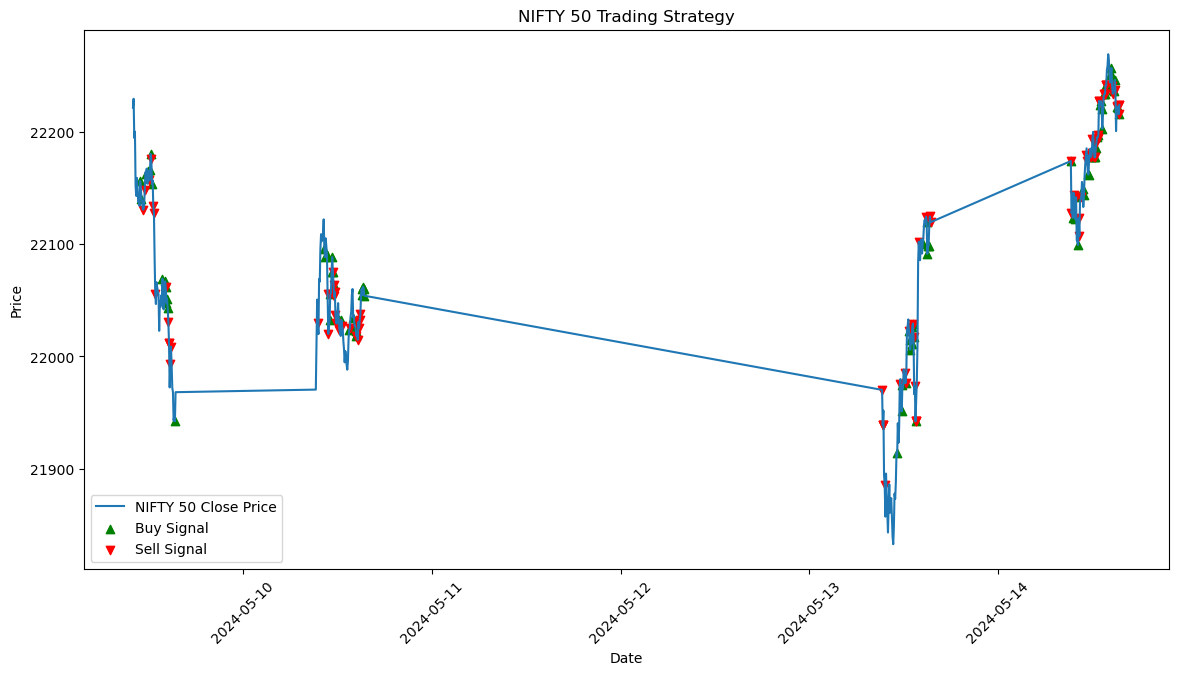

In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Load options data
def load_options_data(folder):
    data_list = []
    for file in os.listdir(folder):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(folder, file))
            data_list.append(df)
    return pd.concat(data_list, ignore_index=True)

# Load NIFTY data
nifty_data = pd.read_csv(r"C:\Users\dubey\OneDrive\Concated Data\NIFTY 50 stock data.csv")
nifty_data['Date'] = pd.to_datetime(nifty_data['Date'], format='%a %b %d %Y %H:%M:%S GMT%z (India Standard Time)', errors='coerce')
nifty_data.dropna(subset=['Date'], inplace=True)
nifty_data.set_index('Date', inplace=True)

call_options = load_options_data(r"C:\Users\dubey\OneDrive\Concated Data\Call option")
put_options = load_options_data(r"C:\Users\dubey\OneDrive\Concated Data\Put Option")

# Function to select the closest OTM option
def select_otm_option(options_df, current_price, option_type):
    if option_type == 'call':
        otm_options = options_df[options_df['Strike Price'] > current_price]
    elif option_type == 'put':
        otm_options = options_df[options_df['Strike Price'] < current_price]
    else:
        raise ValueError("Invalid option type. Must be 'call' or 'put'.")
    
    if otm_options.empty:
        return None
    
    closest_otm_option = otm_options.iloc[(otm_options['Strike Price'] - current_price).abs().argsort()[:1]]
    return closest_otm_option.iloc[0]  # Return the first OTM option

# Initialize variables for tracking trades and returns
trades = []
capital_per_trade = 100000
total_invested = 0
total_pnl = 0

# Function to check for bullish sentiment
def is_bullish(nifty_df, options_df, current_index):
    if current_index < 3:
        return False
    
    current_close = nifty_df.iloc[current_index]['Close']
    prev_close = nifty_df.iloc[current_index - 3]['Close']
    
    if current_close >= prev_close:
        return False
    
    otm_call = select_otm_option(options_df, current_close, 'call')
    if otm_call is None:
        return False
    
    prev_oi = options_df.iloc[current_index - 1]['OI']
    current_oi = options_df.iloc[current_index]['OI']
    
    if current_oi >= prev_oi:
        return False
    
    for j in range(1, 6):
        if current_index + j < len(nifty_df):
            supertrend_nifty = nifty_df.iloc[current_index + j]['Trend Supertrend (7,3)']
            if nifty_df.iloc[current_index + j]['Close'] > supertrend_nifty:
                return True
            
            supertrend_option = options_df.iloc[current_index + j]['Trend Supertrend (7,3)']
            if otm_call['Close'] < supertrend_option:
                return True
    
    return False

# Function to check for bearish sentiment
def is_bearish(nifty_df, options_df, current_index):
    if current_index < 3:
        return False
    
    current_close = nifty_df.iloc[current_index]['Close']
    prev_close = nifty_df.iloc[current_index - 3]['Close']
    
    if current_close <= prev_close:
        return False
    
    otm_put = select_otm_option(options_df, current_close, 'put')
    if otm_put is None:
        return False
    
    prev_oi = options_df.iloc[current_index - 1]['OI']
    current_oi = options_df.iloc[current_index]['OI']
    
    if current_oi >= prev_oi:
        return False
    
    for j in range(1, 6):
        if current_index + j < len(nifty_df):
            supertrend_nifty = nifty_df.iloc[current_index + j]['Trend Supertrend (7,3)']
            if nifty_df.iloc[current_index + j]['Close'] < supertrend_nifty:
                return True
            
            supertrend_option = options_df.iloc[current_index + j]['Trend Supertrend (7,3)']
            if otm_put['Close'] > supertrend_option:
                return True
    
    return False

# Function to simulate trades based on sentiment
def simulate_trades(nifty_df, call_options_df, put_options_df):
    global total_invested, total_pnl
    
    stop_loss_pct = 0.7  # Stop-loss at 70% loss
    take_profit_pct = 2.1  # Take-profit at 100% gain

    for i in range(3, len(nifty_df)):
        if is_bullish(nifty_df, call_options_df, i):
            otm_call = select_otm_option(call_options_df, nifty_df.iloc[i]['Close'], 'call')
            if otm_call is not None and not pd.isna(otm_call['Close']):
                entry_price = otm_call['Close']
                num_contracts = capital_per_trade // entry_price
                entry_value = num_contracts * entry_price

                for j in range(1, 6):
                    if i + j >= len(call_options_df):
                        break
                    current_price = call_options_df.iloc[i + j]['Close']
                    if pd.isna(current_price):
                        continue
                    pnl = (current_price - entry_price) * num_contracts
                    if pnl / entry_value <= -stop_loss_pct:
                        exit_index = i + j
                        exit_price = current_price
                        break
                    elif pnl / entry_value >= take_profit_pct:
                        exit_index = i + j
                        exit_price = current_price
                        break
                else:
                    exit_index = min(i + 5, len(call_options_df) - 1)
                    exit_price = call_options_df.iloc[exit_index]['Close']

                exit_value = num_contracts * exit_price
                pnl = exit_value - entry_value
                total_pnl += pnl
                total_invested += capital_per_trade
                trades.append({
                    'Entry Index': nifty_df.index[i],
                    'Exit Index': nifty_df.index[exit_index] if exit_index < len(nifty_df) else nifty_df.index[-1],
                    'Type': 'Call',
                    'Entry Price': entry_price,
                    'Exit Price': exit_price,
                    'P&L': pnl
                })

        elif is_bearish(nifty_df, put_options_df, i):
            otm_put = select_otm_option(put_options_df, nifty_df.iloc[i]['Close'], 'put')
            if otm_put is not None and not pd.isna(otm_put['Close']):
                entry_price = otm_put['Close']
                num_contracts = capital_per_trade // entry_price
                entry_value = num_contracts * entry_price

                for j in range(1, 6):
                    if i + j >= len(put_options_df):
                        break
                    current_price = put_options_df.iloc[i + j]['Close']
                    if pd.isna(current_price):
                        continue
                    pnl = (current_price - entry_price) * num_contracts
                    if pnl / entry_value <= -stop_loss_pct:
                        exit_index = i + j
                        exit_price = current_price
                        break
                    elif pnl / entry_value >= take_profit_pct:
                        exit_index = i + j
                        exit_price = current_price
                        break
                else:
                    exit_index = min(i + 5, len(put_options_df) - 1)
                    exit_price = put_options_df.iloc[exit_index]['Close']

                exit_value = num_contracts * exit_price
                pnl = exit_value - entry_value
                total_pnl += pnl
                total_invested += capital_per_trade
                trades.append({
                    'Entry Index': nifty_df.index[i],
                    'Exit Index': nifty_df.index[exit_index] if exit_index < len(nifty_df) else nifty_df.index[-1],
                    'Type': 'Put',
                    'Entry Price': entry_price,
                    'Exit Price': exit_price,
                    'P&L': pnl
                })

# Simulate trades
simulate_trades(nifty_data, call_options, put_options)

# Create a dataframe of trades
trades_df = pd.DataFrame(trades)

# Remove rows with NaN values
trades_df.dropna(inplace=True)
print(trades_df)

# Save the results
trades_df.to_csv('231024_Sonali_OptionsFiesta_Trades.csv', index=False)

# Calculate net returns
if total_invested != 0:
    net_returns = total_pnl / total_invested
else:
    net_returns = 0

# Print the net returns
print(f"Net Returns: {net_returns * 100:.2f}%")

# Plot strategy performance
plt.figure(figsize=(14, 7))
plt.plot(nifty_data.index, nifty_data['Close'], label='NIFTY 50 Close Price')
plt.scatter(trades_df['Entry Index'], nifty_data.loc[trades_df['Entry Index'], 'Close'], color='green', label='Buy Signal', marker='^', alpha=1)
plt.scatter(trades_df['Exit Index'], nifty_data.loc[trades_df['Exit Index'], 'Close'], color='red', label='Sell Signal', marker='v', alpha=1)
plt.title('NIFTY 50 Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()
